# estimating mean termination time conditioned on initial number of tips
Tim Tyree<br>
7.20.2023

In [1]:
import sys,os
og_stdout=sys.stdout
from lib.my_initialization import *
os.chdir(nb_dir)
from lib import *
# import cupy, cudf
# from lib.rapids_func import *
import seaborn as sns
import matplotlib.ticker as mtick
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
import seaborn as sns
#reset matplotlib
plt.plot([1]*4)
plt.close()
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

# define module

# compute $\tau(N_0)$

In [78]:
printing=True
use_save_df_to_parquet_by=True
use_save_df_to_parquet_by=False
#load fortranic tip positions
folder=f"{nb_dir}/Data/from_wjr/positions_fk/200x200"
fn = 'tippos_per_c_001'
folder=f"{nb_dir}/Data/from_wjr/positions_lr/200x200"
fn = 'tippos_per_001'
input_dir = os.path.join(folder,fn)
log_folder_parquet=f'{folder}/positions'
assert os.path.exists(input_dir)
if use_save_df_to_parquet_by:
    df_log=parse_fortranic_tip_pos(input_dir)
    #partition df_log into a folder of tip logs
    save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=None)
    print(f"saved to spiral tip positions to {log_folder_parquet=}")
    #determine width and height of the computational domain input the discretization
    width,height=df_log.describe().loc['max'][['x','y']].values.T
    del df_log
else:
    width=200
    height=200

In [79]:
N0=2
t_lst=[]
for fn in os.listdir(log_folder_parquet):
    try:
        trial_num = eval(fn.split('=')[1])
        # load tip position data
        g=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
        n_series = g.groupby(by='t')['n'].min()
        t0_values = n_series[n_series==N0].index.values
        tf = n_series.index.values.max()
        t_values = tf-t0_values
        #record
        t_lst.extend(t_values)
    except IndexError as e:
        pass
        #print(f"IndexError for {fn}: {e}")
n_series.max()

14

In [80]:
# mtt = np.mean(t_lst)
# bootstrap_95CI_Delta_mean?
# plt.hist(t_lst,bins=np.arange(0,10000,100),color='k')
# plt.show()

In [81]:
mtt,Delta_mtt,num_obs,p_normal=comp_mean_bootstrap_uncertainty(np.array(t_lst))
print(f"{mtt=:.2f}±{Delta_mtt:.2f} ms ({num_obs=}, {p_normal=:.4f})")
# mtt=24266.95±197.80 ms (num_obs=81503,p_normal=0.9881103097963074)

mtt=551.57±3.94 ms (num_obs=112062, p_normal=0.5867)


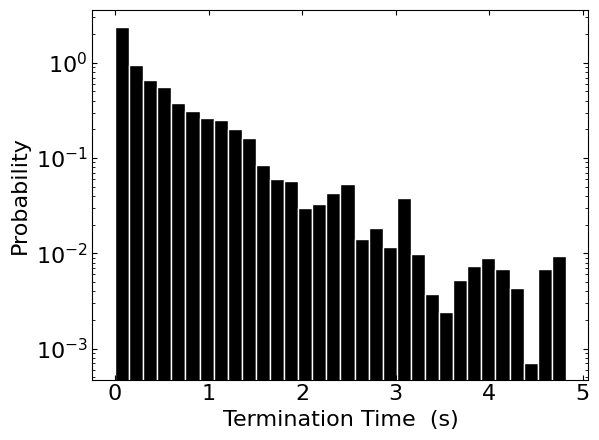

In [82]:
fontsize=16
fig,ax=plt.subplots()
bins=16
# bins=np.arange(0,0.4,0.02)
bins=32
ax.hist(np.array(t_lst)/1e3,color='k',bins=bins,density=True,alpha=1,label='Data',edgecolor='w')#,**kwargs)
format_plot(xlabel='Termination Time  (s)',ylabel='Probability',ax=ax,fontsize=fontsize)
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.set_yscale('log')
plt.show()

# compute $\tau(N_0)$ versus $N_0$

In [83]:
dict_lst=[]
for N0 in range(2,16,2):
    t_lst=[]
    for fn in os.listdir(log_folder_parquet):
        try:
            trial_num = eval(fn.split('=')[1])
            # load tip position data
            g=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
            n_series = g.groupby(by='t')['n'].min()
            t0_values = n_series[n_series==N0].index.values
            tf = n_series.index.values.max()
            t_values = tf-t0_values
            #record
            t_lst.extend(t_values)
        except IndexError as e:
            pass
            #print(f"IndexError for {fn}: {e}")
    mtt,Delta_mtt,num_obs,p_normal=comp_mean_bootstrap_uncertainty(np.array(t_lst))
    dict_lst.append(dict(
        N0=N0,mtt=mtt,Delta_mtt=Delta_mtt,num_obs=num_obs,p_normal=p_normal
    ))
    print(f"{N0=}: {mtt=} ms")

N0=2: mtt=551.566382895183 ms
N0=4: mtt=694.4088721964355 ms
N0=6: mtt=769.820986672323 ms
N0=8: mtt=809.1375994746799 ms
N0=10: mtt=831.2367033676434 ms
N0=12: mtt=891.6356617989024 ms
N0=14: mtt=886.8749024707412 ms


In [84]:
df=pd.DataFrame(dict_lst)
df.head()

,N0,mtt,Delta_mtt,num_obs,p_normal
0,2,551.566383,3.952828,112062,0.497724
1,4,694.408872,3.597160,141115,0.281438
2,6,769.820987,4.070692,113148,0.192640
3,8,809.137599,5.570481,63961,0.029750
4,10,831.236703,8.460279,27883,0.272621


In [85]:
n_series.max()

14

In [86]:
fn_out = os.path.join(folder,'mtt_vs_N0.csv')
df.to_csv(fn_out,index=False)
print(f"csv_dir = '{fn_out}'")

csv_dir = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/mtt_vs_N0.csv'


# visualize mean termination time conditioned on initial number of tips

In [87]:
csv_dir_fk = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/mtt_vs_N0.csv'
csv_dir_lr = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/mtt_vs_N0.csv'

In [88]:
dffk=pd.read_csv(csv_dir_fk)
dflr=pd.read_csv(csv_dir_lr)

In [89]:
yscale=1e-3
x_values1 = dffk['N0'].values
y_values1 = dffk['mtt'].values*yscale
yerr_values1 = dffk['Delta_mtt'].values*yscale
x_values2 = dflr['N0'].values
y_values2 = dflr['mtt'].values*yscale
yerr_values2 = dflr['Delta_mtt'].values*yscale

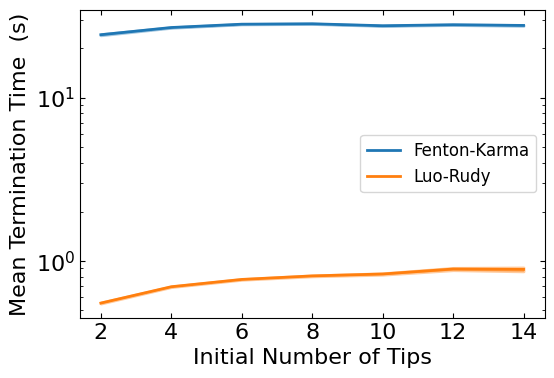

In [96]:
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(x_values1,y_values1,color='C0',lw=2,label='Fenton-Karma')
ax.fill_between(x_values1,y_values1-yerr_values1,y_values1+yerr_values1,color='C0',lw=2,alpha=0.4)

ax.plot(x_values2,y_values2,color='C1',lw=2,label='Luo-Rudy')
ax.fill_between(x_values2,y_values2-yerr_values2,y_values2+yerr_values2,color='C1',lw=2,alpha=0.4)

format_plot(xlabel='Initial Number of Tips',ylabel='Mean Termination Time  (s)',ax=ax,fontsize=fontsize)
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.set_yscale('log')
ax.legend(fontsize=12)
ax.set_xticks([2,4,6,8,10,12,14])
plt.show()

In [102]:
3+1_1

14

In [107]:
np.log(3)/3

0.3662040962227033